# Diffusion Model
https://benchmarks.juliadiffeq.org/html/Jumps/Diffusion_CTRW.html


In [1]:
using DiffEqBase, DiffEqBiological, DiffEqJump, Statistics, DataFrames
using Plots
gr()
fmt = :png

┌ Info: Precompiling DiffEqBiological [eb300fae-53e8-50a0-950c-e21f52c2b7e0]
└ @ Base loading.jl:1273


:png

## Model and example solutions
Here we implement a 1D continuous time random walk approximation of diffusion for N lattice sites on [0,1], with reflecting boundary conditions at x=0 and x=1.

In [2]:
N = 256
h = 1 / N
rn = @empty_reaction_network
function getDiffNetwork!(rn,N)    
    for i = 1:N
        addspecies!(rn, Symbol(:u, i))
    end
    addparam!(rn, :β)
    for i = 1:N
        (i < N) && addreaction!(rn, :β, (Symbol(:u,i)=>1,), (Symbol(:u,i+1)=>1,))
        (i > 1) && addreaction!(rn, :β, (Symbol(:u,i)=>1,), (Symbol(:u,i-1)=>1,))
    end
    rn
end
getDiffNetwork!(rn,N)
addjumps!(rn, build_regular_jumps=false, minimal_jumps=true)
rnpar = [1/(h*h)]
u0 = 10*ones(Int64, N)
tf = .01

0.01

In [10]:
methods = (Direct(),DirectFW(),SortingDirect(),NRM(),DirectCR(),RSSA())
shortlabels = [string(leg)[1:end-2] for leg in methods]
prob    = prob = DiscreteProblem(u0, (0.0, tf), rnpar)
ploth   = plot(reuse=false)
for (i,method) in enumerate(methods)
    println("Benchmarking method: ", method)
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper(), saveat=tf/1000.)
    plot!(ploth,sol.t,sol[Int(N//2),:],label=shortlabels[i], format=fmt)
end

Benchmarking method: Direct()
Benchmarking method: DirectFW()
Benchmarking method: SortingDirect()
Benchmarking method: NRM()
Benchmarking method: DirectCR()
Benchmarking method: RSSA()


In [11]:
plot!(ploth, 
    title="Population at middle lattice site", xlabel="time",format=fmt)

6-element Array{String,1}:
 "Direct"       
 "DirectFW"     
 "SortingDirect"
 "NRM"          
 "DirectCR"     
 "RSSA"         

## Benchmarking performance of the methods

In [12]:
function run_benchmark!(t, jump_prob, stepper)
    sol = solve(jump_prob, stepper)
    @inbounds for i in 1:length(t)
        t[i] = @elapsed (sol = solve(jump_prob, stepper))
    end
end

run_benchmark! (generic function with 1 method)

In [13]:
nsims = 50
benchmarks = Vector{Vector{Float64}}()
for method in methods
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    stepper = SSAStepper()
    t = Vector{Float64}(undef,nsims)
    run_benchmark!(t, jump_prob, stepper)
    push!(benchmarks, t)
end

In [14]:
medtimes = Vector{Float64}(undef,length(methods))
stdtimes = Vector{Float64}(undef,length(methods))
avgtimes = Vector{Float64}(undef,length(methods))
for i in 1:length(methods)
    medtimes[i] = median(benchmarks[i])
    avgtimes[i] = mean(benchmarks[i])
    stdtimes[i] = std(benchmarks[i])
end

df = DataFrame(names=shortlabels,medtimes=medtimes,
    relmedtimes=(medtimes/medtimes[1]),
                avgtimes=avgtimes, std=stdtimes, cv=stdtimes./avgtimes)

,names,medtimes,relmedtimes,avgtimes,std,cv
,String,Float64,Float64,Float64,Float64,Float64
1,Direct,5.86907,1.0,5.88878,0.0783732,0.0133089
2,DirectFW,6.26767,1.06792,6.29392,0.0842559,0.0133869
3,SortingDirect,1.14298,0.194747,1.14359,0.0082506,0.00721466
4,NRM,0.537558,0.0915917,0.539565,0.013425,0.0248812
5,DirectCR,0.459554,0.078301,0.467227,0.0257681,0.0551512
6,RSSA,1.56101,0.265973,1.56723,0.0260478,0.0166203


## Plotting

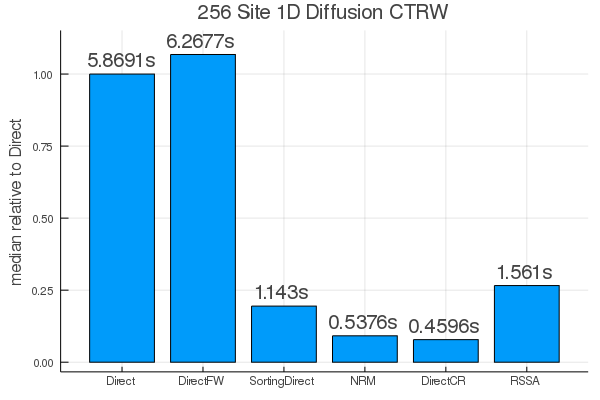

In [16]:
sa = [string(round(mt,digits=4),"s") for mt in df.medtimes]
bar(df.names,df.relmedtimes,legend=:false, fmt=fmt)
scatter!(df.names, .05 .+ df.relmedtimes, 
    markeralpha=0, series_annotations=sa, fmt=fmt)
ylabel!("median relative to Direct")
title!("256 Site 1D Diffusion CTRW")